# Final Evaluation - Part 2

The second part of this assignment is a text classification assignment. Using an existing dataset, develop your best model for how you can predict the genre of a movie based on the plot. While working on this assignment, you should submit multiple predictions to the [course Kaggle site](https://www.kaggle.com/t/98cf8408b2ab467787b5fc9ba11de89f) to check on the accuracy of your model. Your submission on Toledo for this portion will consist of a short (1-3 page) summary of your data analysis that gives an overview of the different methods you tried and evaluate your efforts. You should also include a notebook that replicates two distinct methods that you attempted, including your best fitting model and another method that demonstrates your abilities but didn't necessarily yield the best result for this problem.

## Data Inspection

First of all, we load the dataset and inspect its characteristics.

In [1]:
# load the necessary libraries

import pandas as pd
import seaborn as sns
import numpy as np
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,  accuracy_score, confusion_matrix, f1_score

In [2]:
#load the movies dataset

df = pd.read_csv('train.csv')

In [3]:
df.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
2072,1931,Born to Love,American,Paul L. Stein,"Joel McCrea, Constance Bennett, Paul Cavanagh",drama,https://en.wikipedia.org/wiki/Born_to_Love_(film),Doris Kendall (Constance Bennett) is an Americ...
11117,1993,Indecent Proposal,American,Adrian Lyne,"Robert Redford, Demi Moore, Woody Harrelson",drama,https://en.wikipedia.org/wiki/Indecent_Proposal,High school sweethearts David (Woody Harrelson...
1751,2010,Hanamizuki,Japanese,Nobuhiro Doi,"Yui Aragaki, Toma Ikuta, Misako Renbutsu",romance,https://en.wikipedia.org/wiki/Hanamizuki,This film spans the years of 1996 to 2006.\r\n...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13164 entries, 0 to 13163
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      13164 non-null  int64 
 1   Title             13164 non-null  object
 2   Origin/Ethnicity  13164 non-null  object
 3   Director          13164 non-null  object
 4   Cast              12980 non-null  object
 5   Genre             13164 non-null  object
 6   Wiki Page         13164 non-null  object
 7   Plot              13164 non-null  object
dtypes: int64(1), object(7)
memory usage: 822.9+ KB


In [5]:
df['Genre'].value_counts()

drama        4781
comedy       3503
horror        937
action        890
thriller      768
romance       743
western       678
crime         442
adventure     422
Name: Genre, dtype: int64

Clearly the dataset is not balanced, forcing the more frequent Genres to be classified more accurately. We will have to account for that.

## Training / Validation Datasets

In order not to overfit on the testing dataset on Kaggle, we split the provided training data into our own training and validation datasets (80/20 split). We perform this such that there would be the same proportion of Genres in each dataset. Model training and parameter selection is done using the training dataset, while the final best model is selected using the validation dataset.

In [6]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df, test_size=0.2, stratify=df['Genre'], random_state=13)

In [7]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(validation))

Length of training dataset: 10531
Length of validation dataset: 2633


In [8]:
train['Genre'].value_counts()

drama        3825
comedy       2802
horror        750
action        712
thriller      614
romance       594
western       542
crime         354
adventure     338
Name: Genre, dtype: int64

In [9]:
validation['Genre'].value_counts()

drama        956
comedy       701
horror       187
action       178
thriller     154
romance      149
western      136
crime         88
adventure     84
Name: Genre, dtype: int64

## Model 1: Logistic Regression

Here we try to classify movie plots using logistic regression and different data preprocessing techniques (count vectorizer, TF-IDF, lemmatization, Word2Vec and combinations of them).

#### Model 1.1: Logistic Regression + Count Vectorizer

Convert movie plots to count vectors (remove the stop words first) using count vectorizer and classify the plots to genres using logistic regression classifier (use option class_weight = 'balanced' to account for class imbalance)

In [55]:
# create a pipeline

pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english')),
                     ('classifier' , LogisticRegression(max_iter=5000, class_weight = 'balanced'))
                    ])


# try different parameters values using 3-fold cross-validation to see which parameter combination 
# produces the best results

parameters = {'vectorizer__max_df' : [0.5, 0.7, 0.9],
              'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
              'classifier__C': [0.01, 0.1, 1],
              'classifier__solver': ['liblinear', 'lbfgs']
               }

grid = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [56]:
# fit the pipeline to the training dataset
grid.fit(train['Plot'], train['Genre'])

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.592 total time=   3.5s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.591 total time=   3.4s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.583 total time=   4.0s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.592 total time=  15.0s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.596 total time=  15.8s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorize

[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.579 total time=   3.3s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.590 total time=   5.2s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.591 total time=   5.5s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.583 total time=   5.6s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.590 total time=   7.5s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1

[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.564 total time=   8.1s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.566 total time=  11.1s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.564 total time=  10.1s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.564 total time=  10.6s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.556 total time=   3.5s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.555 total

[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.559 total time=   4.3s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.554 total time=   3.9s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.558 total time=   4.2s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.566 total time=   8.9s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.564 total time=   8.7s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.564 total

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.590 total time=  21.6s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.587 total time=  21.9s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.585 total time=  21.4s
[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.590 total time=  45.9s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.587 total time=  49.0s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);,

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.584 total time=   8.7s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.584 total time=   8.7s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.586 total time=   8.7s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.573 total time=   9.1s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.578 total time=   8.8s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.573

[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.569 total time=   5.0s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.571 total time=   4.6s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.576 total time=   8.6s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.575 total time=   8.6s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.576 total time=   8.4s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.576 total time=

[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.567 total time=   8.9s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.565 total time=  11.1s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.568 total time=  11.9s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.567 total time=  11.1s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.556 total time=   5.1s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.558

[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.556 total time=   5.5s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.560 total time=   5.6s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.563 total time=   5.4s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.567 total time=   9.6s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.567 total time=   9.6s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.567

[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.575 total time= 3.6min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.573 total time= 2.8min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.574 total time= 9.9min
[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.579 total time= 8.2min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.578 total time= 6.2min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.553 total time=   8.6s
[CV 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'vectorizer__max_df': [0.5, 0.7, 0.9],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [57]:
print("The best algorithm:", grid.best_estimator_)
print("Score of the best algorithm:", grid.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=5000, solver='liblinear'))])
Score of the best algorithm: 0.5911794968294538


In [58]:
# CV results sorted by their rank in terms of the test score
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,param_vectorizer__max_df,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,14.610305,0.451872,1.167569,0.051779,0.01,liblinear,0.5,1,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.592319,0.596104,0.585116,0.591179,0.004558,1
19,15.416353,0.704737,1.208116,0.033999,0.01,liblinear,0.9,1,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.592319,0.596104,0.585116,0.591179,0.004558,1
10,15.566691,0.247288,1.169904,0.020062,0.01,liblinear,0.7,1,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.592319,0.596104,0.585116,0.591179,0.004558,1
23,7.020205,0.221458,1.510968,0.103091,0.01,liblinear,0.9,3,"(1, 3)","{'classifier__C': 0.01, 'classifier__solver': ...",0.589589,0.593169,0.584712,0.589156,0.003466,4
5,6.803837,0.151451,1.514144,0.026992,0.01,liblinear,0.5,3,"(1, 3)","{'classifier__C': 0.01, 'classifier__solver': ...",0.589589,0.593169,0.584712,0.589156,0.003466,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,6.646264,0.673855,0.683530,0.017244,1,lbfgs,0.5,5,"(1, 1)","{'classifier__C': 1, 'classifier__solver': 'lb...",0.551749,0.556129,0.557558,0.555145,0.002472,157
159,7.365603,0.726439,0.687188,0.007091,1,lbfgs,0.9,5,"(1, 1)","{'classifier__C': 1, 'classifier__solver': 'lb...",0.551749,0.556129,0.557558,0.555145,0.002472,157
42,3.307902,0.027313,0.651616,0.025239,0.01,lbfgs,0.7,5,"(1, 1)","{'classifier__C': 0.01, 'classifier__solver': ...",0.556254,0.554688,0.553244,0.554729,0.001229,160
51,3.397947,0.028210,0.640979,0.010129,0.01,lbfgs,0.9,5,"(1, 1)","{'classifier__C': 0.01, 'classifier__solver': ...",0.556254,0.554688,0.553244,0.554729,0.001229,160


In [59]:
# predict genres of the movie plots in the validation dataset and output the weighted f1-score using the best model
best_pipe = grid.best_estimator_
lr_prediction_validation = best_pipe.predict(validation['Plot'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation, average='weighted'))

Validation accuracy of the best algorithm: 0.600932198001135


<AxesSubplot:>

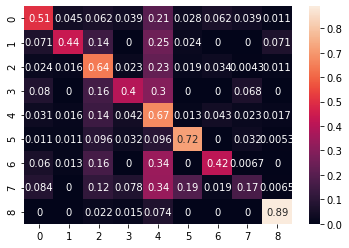

In [60]:
# show the confusion matrix of validation predictions, normalized along the true labels (normalized rows)
cm = confusion_matrix(validation['Genre'], lr_prediction_validation, normalize='true')
sns.heatmap(cm, annot=True)

In [61]:
# print the classification report of the validation dataset
print(classification_report(validation['Genre'], lr_prediction_validation))

              precision    recall  f1-score   support

      action       0.52      0.51      0.51       178
   adventure       0.49      0.44      0.47        84
      comedy       0.66      0.64      0.65       701
       crime       0.30      0.40      0.34        88
       drama       0.63      0.67      0.65       956
      horror       0.69      0.72      0.70       187
     romance       0.44      0.42      0.43       149
    thriller       0.37      0.17      0.23       154
     western       0.78      0.89      0.83       136

    accuracy                           0.61      2633
   macro avg       0.54      0.54      0.53      2633
weighted avg       0.60      0.61      0.60      2633



In [63]:
# apply the best model to the testing dataset and save the results

test = pd.read_csv('test.csv')
test['Predicted'] = best_pipe.predict(test['Plot'])
test[['Id','Predicted']].to_csv('my_submissions_model_1-1.csv', index=False)

#### Model 1.2: Logistic Regression + TFIDF

Do everything the same as above, except convert count vectors of movie plots to TF-IDF vectors 

In [64]:
# CountVectorizer + TfidfTransformer produces the same results as simple TdidfVectorizer)

pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english')),
                     ('tf_transfomer', TfidfTransformer(use_idf = True)),
                     ('classifier' , LogisticRegression(max_iter=5000, class_weight = 'balanced'))
                    ])

parameters = {'vectorizer__max_df' : [0.5, 0.7, 0.9],
              'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
              'classifier__C': [0.01, 0.1, 1],
              'classifier__solver': ['liblinear', 'lbfgs']
               }

grid12 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [65]:
grid12.fit(train['Plot'], train['Genre'])

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.193 total time=   2.4s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.4s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.5s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.193 total time=  10.9s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.194 total time=  12.0s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorize

[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.3s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.193 total time=   4.4s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.194 total time=   4.3s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.194 total time=   4.5s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.193 total time=   6.6s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1

[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.411 total time=   4.9s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.408 total time=   7.0s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.403 total time=   7.1s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.412 total time=   7.0s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.389 total time=   2.2s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.398 total

[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.399 total time=   2.4s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.398 total time=   2.3s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.405 total time=   2.4s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.407 total time=   4.7s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.404 total time=   4.8s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.411 total

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.281 total time=  10.1s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.273 total time=  10.1s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.280 total time=  10.0s
[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.241 total time=  19.8s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.237 total time=  19.8s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);,

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.472 total time=   6.6s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.464 total time=   6.8s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.472 total time=   6.8s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.455 total time=   4.2s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.445 total time=   3.9s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.462

[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.449 total time=   2.7s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.455 total time=   2.6s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.461 total time=   4.8s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.452 total time=   4.8s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.462 total time=   5.2s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.460 total time=

[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.591 total time=   5.0s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.596 total time=   7.3s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.597 total time=   7.4s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.592 total time=   7.5s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.586 total time=   2.6s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.589

[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.589 total time=   2.7s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.591 total time=   2.8s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.590 total time=   2.8s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.595 total time=   5.2s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.598 total time=   5.0s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.591

[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.567 total time= 1.6min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.560 total time= 1.5min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.555 total time= 3.3min
[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.556 total time= 3.8min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.551 total time= 3.5min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.564 total time=   5.2s
[CV 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'vectorizer__max_df': [0.5, 0.7, 0.9],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [66]:
print("The best algorithm:", grid12.best_estimator_)
print("Score of the best algorithm:", grid12.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 3),
                                 stop_words='english')),
                ('tf_transfomer', TfidfTransformer()),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=5000,
                                    solver='liblinear'))])
Score of the best algorithm: 0.5949722610861515


In [67]:
pd.DataFrame(grid12.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,param_vectorizer__max_df,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
131,5.944196,0.053806,1.514296,0.043055,1,liblinear,0.9,3,"(1, 3)","{'classifier__C': 1, 'classifier__solver': 'li...",0.595576,0.597247,0.592094,0.594972,0.002147,1
122,5.910165,0.038168,1.478735,0.011308,1,liblinear,0.7,3,"(1, 3)","{'classifier__C': 1, 'classifier__solver': 'li...",0.595576,0.597247,0.592094,0.594972,0.002147,1
113,5.971335,0.065401,1.508665,0.024972,1,liblinear,0.5,3,"(1, 3)","{'classifier__C': 1, 'classifier__solver': 'li...",0.595576,0.597247,0.592094,0.594972,0.002147,1
121,4.169485,0.041383,1.109733,0.015759,1,liblinear,0.7,3,"(1, 2)","{'classifier__C': 1, 'classifier__solver': 'li...",0.595384,0.597575,0.591285,0.594748,0.002607,4
112,4.086724,0.036521,1.091763,0.021481,1,liblinear,0.5,3,"(1, 2)","{'classifier__C': 1, 'classifier__solver': 'li...",0.595384,0.597575,0.591285,0.594748,0.002607,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1.669155,0.018133,0.688503,0.007688,0.01,liblinear,0.9,5,"(1, 1)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
25,3.330418,0.022023,1.067833,0.009846,0.01,liblinear,0.9,5,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
26,5.140588,0.065836,1.464786,0.014349,0.01,liblinear,0.9,5,"(1, 3)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
13,3.565446,0.033178,1.095428,0.016439,0.01,liblinear,0.7,3,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136


In [68]:
best_pipe12 = grid12.best_estimator_
lr_prediction_validation12 = best_pipe12.predict(validation['Plot'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation12, average='weighted'))

Validation accuracy of the best algorithm: 0.5991451297588226


<AxesSubplot:>

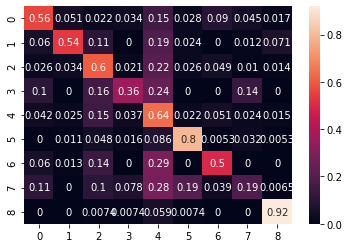

In [69]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation12, normalize='true')
sns.heatmap(cm, annot=True)

In [70]:
print(classification_report(validation['Genre'], lr_prediction_validation12))

              precision    recall  f1-score   support

      action       0.51      0.56      0.53       178
   adventure       0.42      0.54      0.47        84
      comedy       0.66      0.60      0.63       701
       crime       0.31      0.36      0.33        88
       drama       0.65      0.64      0.64       956
      horror       0.66      0.80      0.72       187
     romance       0.41      0.50      0.45       149
    thriller       0.34      0.19      0.24       154
     western       0.78      0.92      0.84       136

    accuracy                           0.60      2633
   macro avg       0.53      0.57      0.54      2633
weighted avg       0.60      0.60      0.60      2633



In [71]:
test = pd.read_csv('test.csv')
test['Predicted'] = best_pipe12.predict(test['Plot'])
test[['Id','Predicted']].to_csv('my_submissions_model_1-2.csv', index=False)

#### Model 1.3: Logistic Regression + TFIDF + Lemmatization (+SMOTE)

Do everything the same as above, except also perform lemmatization on the movie plots before running the pipeline. Also, perform SMOTE on the best model to deal with class imbalance.

In [ ]:
#### Without SMOTE

In [12]:
# Create function to lemmatize plots

import spacy
nlp = spacy.load('en_core_web_md')
  
def lemmatize_sentence(plot):
    plot_nlp = nlp(plot)
    lemmatized_sentence = " ".join([token.lemma_ for token in plot_nlp])
    return lemmatized_sentence

In [13]:
# Lemmatize movie plots in train and validation datasets

train['Plot_lemmatized'] = train['Plot'].apply(lemmatize_sentence)
validation['Plot_lemmatized'] = validation['Plot'].apply(lemmatize_sentence)

<ipython-input-13-b1bbafc48cac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_lemmatized'] = train['Plot'].apply(lemmatize_sentence)
<ipython-input-13-b1bbafc48cac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_lemmatized'] = validation['Plot'].apply(lemmatize_sentence)


In [14]:
pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english')),
                     ('tf_transfomer', TfidfTransformer(use_idf = True)),
                     ('classifier' , LogisticRegression(max_iter=5000, class_weight = 'balanced'))
                    ])

parameters = {'vectorizer__max_df' : [0.5, 0.7, 0.9],
              'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,1), (1,2), (1,3)],
              'classifier__C': [0.01, 0.1, 1],
              'classifier__solver': ['liblinear', 'lbfgs']
               }

grid13 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [15]:
grid13.fit(train['Plot_lemmatized'], train['Genre'])

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.193 total time=   2.2s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.2s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.2s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.193 total time=   8.2s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.194 total time=   8.1s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorize

[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.194 total time=   2.1s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.193 total time=   4.0s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.194 total time=   4.0s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.194 total time=   4.1s
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.193 total time=   6.1s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1

[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.421 total time=   4.8s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.418 total time=   7.3s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.404 total time=   7.0s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.421 total time=   7.5s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.400 total time=   2.0s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.393 total

[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.408 total time=   2.1s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.392 total time=   2.1s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.413 total time=   2.1s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.418 total time=   4.5s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.404 total time=   4.6s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.421 total

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.312 total time=   8.9s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.307 total time=   9.0s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.314 total time=   9.1s
[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.271 total time=  18.3s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.264 total time=  18.4s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);,

[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.509 total time=   6.2s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.501 total time=   6.2s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.512 total time=   6.4s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.469 total time=   3.3s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.448 total time=   3.3s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.5, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.466

[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.458 total time=   2.4s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.468 total time=   2.3s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.470 total time=   4.8s
[CV 2/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.458 total time=   4.9s
[CV 3/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2);, score=0.469 total time=   4.9s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=5, vectorizer__ngram_range=(1, 3);, score=0.470 total time=

[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.598 total time=   4.8s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.603 total time=   7.0s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.607 total time=   7.0s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__ngram_range=(1, 3);, score=0.598 total time=   7.0s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.599 total time=   2.4s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.5, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.603

[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.598 total time=   2.4s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.600 total time=   2.4s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.593 total time=   2.4s
[CV 1/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.603 total time=   4.8s
[CV 2/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.607 total time=   4.9s
[CV 3/3] END classifier__C=1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.598

[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.576 total time= 1.6min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.569 total time= 1.4min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.559 total time= 3.0min
[CV 2/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.565 total time= 3.2min
[CV 3/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.561 total time= 3.2min
[CV 1/3] END classifier__C=1, classifier__solver=lbfgs, vectorizer__max_df=0.7, vectorizer__min_df=3, vectorizer__ngram_range=(1, 1);, score=0.569 total time=   4.5s
[CV 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'vectorizer__max_df': [0.5, 0.7, 0.9],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [16]:
print("The best algorithm:", grid13.best_estimator_)
print("Score of the best algorithm:", grid13.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tf_transfomer', TfidfTransformer()),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=5000,
                                    solver='liblinear'))])
Score of the best algorithm: 0.6028723866187733


In [17]:
pd.DataFrame(grid13.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,param_vectorizer__max_df,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
130,3.909846,0.065715,1.045570,0.007826,1,liblinear,0.9,3,"(1, 2)","{'classifier__C': 1, 'classifier__solver': 'li...",0.603258,0.607059,0.598300,0.602872,0.003586,1
121,3.881590,0.029931,1.051543,0.015635,1,liblinear,0.7,3,"(1, 2)","{'classifier__C': 1, 'classifier__solver': 'li...",0.603258,0.607059,0.598300,0.602872,0.003586,1
112,3.902866,0.026566,1.044233,0.009775,1,liblinear,0.5,3,"(1, 2)","{'classifier__C': 1, 'classifier__solver': 'li...",0.603258,0.607059,0.598300,0.602872,0.003586,1
131,5.585698,0.049005,1.444158,0.031419,1,liblinear,0.9,3,"(1, 3)","{'classifier__C': 1, 'classifier__solver': 'li...",0.603044,0.607414,0.597763,0.602740,0.003946,4
122,5.737969,0.011707,1.434529,0.015372,1,liblinear,0.7,3,"(1, 3)","{'classifier__C': 1, 'classifier__solver': 'li...",0.603044,0.607414,0.597763,0.602740,0.003946,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1.508990,0.011928,0.635999,0.010629,0.01,liblinear,0.9,5,"(1, 1)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
25,3.241049,0.094884,1.081120,0.060258,0.01,liblinear,0.9,5,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
26,4.836046,0.042393,1.416565,0.009714,0.01,liblinear,0.9,5,"(1, 3)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136
13,3.297483,0.002488,1.046898,0.010313,0.01,liblinear,0.7,3,"(1, 2)","{'classifier__C': 0.01, 'classifier__solver': ...",0.193485,0.193580,0.193580,0.193549,0.000045,136


In [18]:
best_pipe13 = grid13.best_estimator_
lr_prediction_validation13 = best_pipe13.predict(validation['Plot_lemmatized'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation13, average='weighted'))

Validation accuracy of the best algorithm: 0.6052837992659263


<AxesSubplot:>

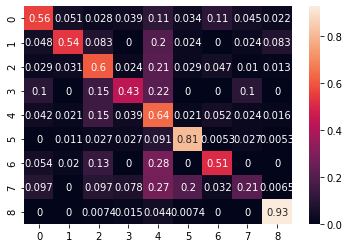

In [19]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation13, normalize='true')
sns.heatmap(cm, annot=True)

In [20]:
print(classification_report(validation['Genre'], lr_prediction_validation13))

              precision    recall  f1-score   support

      action       0.51      0.56      0.53       178
   adventure       0.45      0.54      0.49        84
      comedy       0.67      0.60      0.64       701
       crime       0.32      0.43      0.37        88
       drama       0.66      0.64      0.65       956
      horror       0.65      0.81      0.72       187
     romance       0.41      0.51      0.46       149
    thriller       0.38      0.21      0.27       154
     western       0.77      0.93      0.84       136

    accuracy                           0.61      2633
   macro avg       0.54      0.58      0.55      2633
weighted avg       0.61      0.61      0.61      2633



In [21]:
test = pd.read_csv('test.csv')
test_plot_lemmatized = test['Plot'].apply(lemmatize_sentence)
test['Predicted'] = best_pipe13.predict(test_plot_lemmatized)
test[['Id','Predicted']].to_csv('my_submissions_model_1-3.csv', index=False)

In [ ]:
### Best model with SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [28]:
pipeline = make_pipeline(CountVectorizer(stop_words='english', max_df=0.9, min_df=3, ngram_range=(1,2)),
                         TfidfTransformer(use_idf=True),
                         SMOTE(random_state=13, n_jobs = -1),
                         LogisticRegression(max_iter=5000, solver='liblinear', C=1))

In [29]:
pipeline.fit(train['Plot_lemmatized'], train['Genre'])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidftransformer', TfidfTransformer()),
                ('smote', SMOTE(n_jobs=-1, random_state=13)),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=5000, solver='liblinear'))])

In [30]:
lr_prediction_validation13_smote = pipeline.predict(validation['Plot_lemmatized'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation13_smote, average='weighted'))

Validation accuracy of the best algorithm: 0.6000340615206304


<AxesSubplot:>

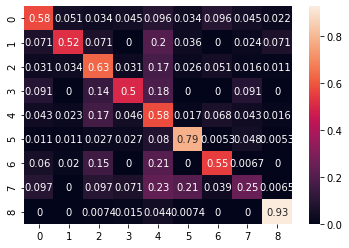

In [31]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation13_smote, normalize='true')
sns.heatmap(cm, annot=True)

In [32]:
print(classification_report(validation['Genre'], lr_prediction_validation13_smote))

              precision    recall  f1-score   support

      action       0.50      0.58      0.54       178
   adventure       0.42      0.52      0.47        84
      comedy       0.66      0.63      0.64       701
       crime       0.32      0.50      0.39        88
       drama       0.68      0.58      0.63       956
      horror       0.66      0.79      0.72       187
     romance       0.40      0.55      0.46       149
    thriller       0.32      0.25      0.28       154
     western       0.78      0.93      0.85       136

    accuracy                           0.60      2633
   macro avg       0.53      0.59      0.55      2633
weighted avg       0.61      0.60      0.60      2633



In [33]:
test = pd.read_csv('test.csv')
test_plot_lemmatized = test['Plot'].apply(lemmatize_sentence)
test['Predicted'] = pipeline.predict(test_plot_lemmatized)
test[['Id','Predicted']].to_csv('my_submissions_model_1-3_smote.csv', index=False)

Using SMOTE to handle class imbalance instead did not yield better results.

#### Model 1.4: Logistic Regression +  Word2Vec

Remove punctuation from movie plots and split words into tokens. Then convert words to vectors using a pre-trained word2vec model and create a representative vector for each movie by averaging over word vectors of that movie's plot. Use the resulting plot vector representations to classify the plots to genres using logistic regression classifier.

In [34]:
# Function to remove punctuation and convert words into tokens

def fast_tokenize(text):
    
    # Get a list of punctuation marks
    punct = string.punctuation + '“' + '”' + '‘' + "’"
    
    lower_case = text.lower()
    lower_case = lower_case.replace('—', ' ').replace('\n', ' ')
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in lower_case if char not in punct])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

In [35]:
import gensim.downloader as api
gn_model = api.load('word2vec-google-news-300')

C:\Users\aistm\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [36]:
# Create function to produce document vectors by averaging over word vectors and remove out-of-vocabulary words

def document_vector(doc):
    tokens = fast_tokenize(doc)
    words = [word for word in tokens if word in gn_model]
    return np.mean(gn_model[words], axis=0)

In [37]:
train['Plot_w2v'] = train['Plot'].apply(document_vector)
validation['Plot_w2v'] = validation['Plot'].apply(document_vector)

<ipython-input-37-77cabf4aead4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_w2v'] = train['Plot'].apply(document_vector)
<ipython-input-37-77cabf4aead4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_w2v'] = validation['Plot'].apply(document_vector)


In [38]:
pipeline = Pipeline([
                     ('classifier' , LogisticRegression(max_iter=5000, class_weight = 'balanced'))
                    ])

parameters = {
              'classifier__C': [0.01, 0.1, 1],
              'classifier__solver': ['liblinear', 'lbfgs']
               }

grid14 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [39]:
grid14.fit(list(train['Plot_w2v']), train['Genre'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.197 total time=   0.6s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.198 total time=   0.6s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.198 total time=   0.6s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.252 total time=   0.6s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.248 total time=   0.0s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.248 total time=   0.0s
[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.516 total time=   1.0s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.507 total time=   1.0s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.512 total time=   0.9s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.354 total time=   0.1s
[CV 2/3] E

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='f1_weighted', verbose=3)

In [40]:
print("The best algorithm:", grid14.best_estimator_)
print("Score of the best algorithm:", grid14.best_score_)

The best algorithm: Pipeline(steps=[('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=5000,
                                    solver='liblinear'))])
Score of the best algorithm: 0.5546925702823794


In [41]:
pd.DataFrame(grid14.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,1.713765,0.096535,0.016611,0.000462,1,liblinear,"{'classifier__C': 1, 'classifier__solver': 'li...",0.555812,0.557191,0.551075,0.554693,0.002620,1
2,1.077145,0.048123,0.017262,0.000947,0.1,liblinear,"{'classifier__C': 0.1, 'classifier__solver': '...",0.516219,0.507265,0.512069,0.511851,0.003659,2
5,0.562496,0.040886,0.018616,0.002351,1,lbfgs,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.482281,0.486319,0.494066,0.487555,0.004890,3
3,0.200466,0.019149,0.017951,0.002155,0.1,lbfgs,"{'classifier__C': 0.1, 'classifier__solver': '...",0.353716,0.341089,0.359058,0.351287,0.007534,4
1,0.276773,0.251942,0.017297,0.000463,0.01,lbfgs,"{'classifier__C': 0.01, 'classifier__solver': ...",0.251547,0.247848,0.248280,0.249225,0.001651,5
0,0.695811,0.020683,0.020285,0.006130,0.01,liblinear,"{'classifier__C': 0.01, 'classifier__solver': ...",0.196923,0.197723,0.197549,0.197398,0.000344,6


In [42]:
best_pipe14 = grid14.best_estimator_
lr_prediction_validation14 = best_pipe14.predict(list(validation['Plot_w2v']))
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation14, average='weighted'))

Validation accuracy of the best algorithm: 0.562424266389368


<AxesSubplot:>

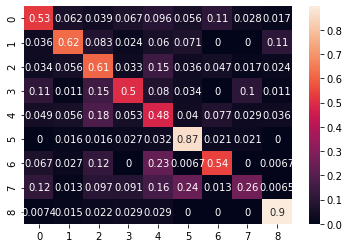

In [43]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation14, normalize='true')
sns.heatmap(cm, annot=True)

In [44]:
print(classification_report(validation['Genre'], lr_prediction_validation14))

              precision    recall  f1-score   support

      action       0.45      0.53      0.49       178
   adventure       0.31      0.62      0.41        84
      comedy       0.64      0.61      0.62       701
       crime       0.28      0.50      0.36        88
       drama       0.70      0.48      0.57       956
      horror       0.57      0.87      0.69       187
     romance       0.38      0.54      0.45       149
    thriller       0.41      0.26      0.32       154
     western       0.65      0.90      0.75       136

    accuracy                           0.56      2633
   macro avg       0.49      0.59      0.52      2633
weighted avg       0.59      0.56      0.56      2633



In [45]:
test = pd.read_csv('test.csv')
test_plot_w2v = test['Plot'].apply(document_vector)
test['Predicted'] = best_pipe14.predict(list(test_plot_w2v))
test[['Id','Predicted']].to_csv('my_submissions_model_1-4.csv', index=False)

#### Model 1.5: Logistic Regression + Lemmatization + Word2Vec

Do everything the same as above, except also perform lemmatization on the movie plots before applying document_vector function. 

In [46]:
train['Plot_w2v_lemmatized'] = train['Plot_lemmatized'].apply(document_vector)
validation['Plot_w2v_lemmatized'] = validation['Plot_lemmatized'].apply(document_vector)

<ipython-input-46-1a664ee817aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_w2v_lemmatized'] = train['Plot_lemmatized'].apply(document_vector)
<ipython-input-46-1a664ee817aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_w2v_lemmatized'] = validation['Plot_lemmatized'].apply(document_vector)


In [47]:
pipeline = Pipeline([
                     ('classifier' , LogisticRegression(max_iter=5000, class_weight = 'balanced'))
                    ])

parameters = {
              'classifier__C': [0.01, 0.1, 1],
              'classifier__solver': ['liblinear', 'lbfgs']
               }

grid15 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [48]:
grid15.fit(list(train['Plot_w2v_lemmatized']), train['Genre'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.196 total time=   0.8s
[CV 2/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.197 total time=   0.6s
[CV 3/3] END classifier__C=0.01, classifier__solver=liblinear;, score=0.197 total time=   0.7s
[CV 1/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.238 total time=   0.0s
[CV 2/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.238 total time=   0.0s
[CV 3/3] END classifier__C=0.01, classifier__solver=lbfgs;, score=0.247 total time=   0.0s
[CV 1/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.502 total time=   0.9s
[CV 2/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.495 total time=   1.0s
[CV 3/3] END classifier__C=0.1, classifier__solver=liblinear;, score=0.503 total time=   1.0s
[CV 1/3] END classifier__C=0.1, classifier__solver=lbfgs;, score=0.338 total time=   0.1s
[CV 2/3] E

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__solver': ['liblinear', 'lbfgs']},
             scoring='f1_weighted', verbose=3)

In [49]:
print("The best algorithm:", grid15.best_estimator_)
print("Score of the best algorithm:", grid15.best_score_)

The best algorithm: Pipeline(steps=[('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=5000,
                                    solver='liblinear'))])
Score of the best algorithm: 0.5467035168892838


In [50]:
pd.DataFrame(grid15.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,1.594081,0.013866,0.015946,1.607200e-05,1,liblinear,"{'classifier__C': 1, 'classifier__solver': 'li...",0.551988,0.546871,0.541251,0.546704,0.004385,1
2,1.043898,0.036359,0.015934,1.645722e-05,0.1,liblinear,"{'classifier__C': 0.1, 'classifier__solver': '...",0.502393,0.494908,0.502883,0.500062,0.003649,2
5,0.519278,0.045895,0.016954,5.840039e-07,1,lbfgs,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.477862,0.477009,0.483875,0.479582,0.003056,3
3,0.188164,0.011117,0.017286,1.880705e-03,0.1,lbfgs,"{'classifier__C': 0.1, 'classifier__solver': '...",0.338129,0.331489,0.352783,0.340801,0.008896,4
1,0.082446,0.005299,0.016289,4.698531e-04,0.01,lbfgs,"{'classifier__C': 0.01, 'classifier__solver': ...",0.237879,0.238267,0.247200,0.241115,0.004306,5
0,0.787251,0.066023,0.018605,2.516774e-03,0.01,liblinear,"{'classifier__C': 0.01, 'classifier__solver': ...",0.196042,0.197121,0.197064,0.196742,0.000496,6


In [51]:
best_pipe15 = grid15.best_estimator_
lr_prediction_validation15 = best_pipe15.predict(list(validation['Plot_w2v_lemmatized']))
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation15, average='weighted'))

Validation accuracy of the best algorithm: 0.5572336405495175


<AxesSubplot:>

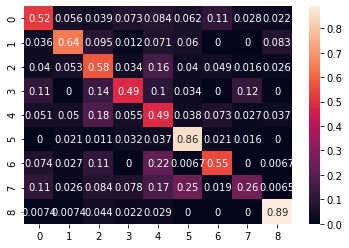

In [52]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation15, normalize='true')
sns.heatmap(cm, annot=True)

In [53]:
print(classification_report(validation['Genre'], lr_prediction_validation15))

              precision    recall  f1-score   support

      action       0.44      0.52      0.48       178
   adventure       0.33      0.64      0.44        84
      comedy       0.63      0.58      0.60       701
       crime       0.28      0.49      0.35        88
       drama       0.68      0.49      0.57       956
      horror       0.57      0.86      0.69       187
     romance       0.38      0.55      0.45       149
    thriller       0.42      0.26      0.32       154
     western       0.65      0.89      0.75       136

    accuracy                           0.56      2633
   macro avg       0.49      0.59      0.52      2633
weighted avg       0.59      0.56      0.56      2633



In [54]:
test = pd.read_csv('test.csv')
test_plot_w2v_lemmatized = test_plot_lemmatized.apply(document_vector)
test['Predicted'] = best_pipe15.predict(list(test_plot_w2v_lemmatized))
test[['Id','Predicted']].to_csv('my_submissions_model_1-5.csv', index=False)

## Model 2: SVM

Here we run everything exactly the same as in the previous section on logistic regression, but we perform the classification with SVM instead.

#### Model 2.1: SVM + Count Vectorizer

In [76]:
from sklearn import svm

pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english', max_df=0.7)),
                     ('classifier' , svm.SVC(class_weight = 'balanced', kernel = 'linear'))
                    ])

parameters = {'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,2), (1,3)],
              'classifier__C': [0.1, 1]
               }

grid21 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [77]:
grid21.fit(train['Plot'], train['Genre'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.531 total time= 2.3min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.542 total time= 2.2min
[CV 3/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.539 total time= 2.2min
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.524 total time= 3.5min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.538 total time= 3.3min
[CV 3/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.541 total time= 3.3min
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.528 total time= 1.2min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.541 total time= 1.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_df=0.7,
                                                        stop_words='english')),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            kernel='linear'))]),
             param_grid={'classifier__C': [0.1, 1],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [78]:
print("The best algorithm:", grid21.best_estimator_)
print("Score of the best algorithm:", grid21.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', kernel='linear'))])
Score of the best algorithm: 0.5375670182321332


In [79]:
pd.DataFrame(grid21.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,107.143579,2.493150,27.568328,0.555629,0.1,1,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 1...",0.531245,0.542030,0.539427,0.537567,0.004595,1
2,53.558236,0.587266,20.087866,0.912285,0.1,3,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.528193,0.540648,0.541377,0.536739,0.006051,2
3,58.763751,3.430092,20.361927,1.035315,0.1,3,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.527965,0.540649,0.540762,0.536459,0.006006,3
4,47.889784,0.884060,18.112629,0.341542,0.1,5,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.533138,0.538181,0.532975,0.534764,0.002417,4
5,50.154267,0.309684,18.890699,0.138892,0.1,5,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.533654,0.536180,0.534445,0.534760,0.001055,5
1,167.288183,5.938511,34.752498,0.303375,0.1,1,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 1...",0.524137,0.537601,0.540657,0.534131,0.007177,6
6,106.623535,3.385478,28.238591,0.510512,1,1,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.526780,0.535229,0.534321,0.532110,0.003787,7
7,165.285342,1.448938,34.760109,0.154738,1,1,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.522774,0.533281,0.539719,0.531925,0.006984,8
9,57.550208,3.078285,20.744877,0.413512,1,3,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.524856,0.525612,0.520104,0.523524,0.002438,9
8,56.000976,1.236723,19.962225,0.178147,1,3,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.522749,0.526078,0.518866,0.522564,0.002947,10


In [80]:
best_pipe21 = grid21.best_estimator_
lr_prediction_validation21 = best_pipe21.predict(validation['Plot'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation21, average='weighted'))

Validation accuracy of the best algorithm: 0.554917436450228


<AxesSubplot:>

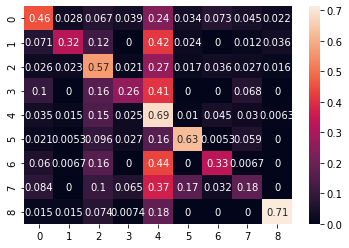

In [81]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation21, normalize='true')
sns.heatmap(cm, annot=True)

In [82]:
print(classification_report(validation['Genre'], lr_prediction_validation21))

              precision    recall  f1-score   support

      action       0.46      0.46      0.46       178
   adventure       0.41      0.32      0.36        84
      comedy       0.62      0.57      0.59       701
       crime       0.27      0.26      0.27        88
       drama       0.58      0.69      0.63       956
      horror       0.68      0.63      0.65       187
     romance       0.36      0.33      0.34       149
    thriller       0.26      0.18      0.21       154
     western       0.80      0.71      0.75       136

    accuracy                           0.56      2633
   macro avg       0.49      0.46      0.47      2633
weighted avg       0.55      0.56      0.55      2633



In [83]:
test = pd.read_csv('test.csv')
test['Predicted'] = best_pipe21.predict(test['Plot'])
test[['Id','Predicted']].to_csv('my_submissions_model_2-1.csv', index=False)

#### Model 2.2: SVM Regression + TFIDF

In [84]:
pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english', max_df=0.7)),
                     ('tf_transfomer', TfidfTransformer(use_idf=True)),
                     ('classifier' , svm.SVC(class_weight = 'balanced', kernel = 'linear'))
                    ])

parameters = {'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,2), (1,3)],
              'classifier__C': [0.1, 1]
               }

grid22 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    #n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [85]:
grid22.fit(train['Plot'], train['Genre'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.060 total time= 3.5min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.131 total time= 3.6min
[CV 3/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.130 total time= 3.3min
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.016 total time= 4.3min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.115 total time= 4.5min
[CV 3/3] END classifier__C=0.1, vectorizer__min_df=1, vectorizer__ngram_range=(1, 3);, score=0.115 total time= 4.6min
[CV 1/3] END classifier__C=0.1, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.400 total time= 2.3min
[CV 2/3] END classifier__C=0.1, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2);, score=0.237 total time= 2.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_df=0.7,
                                                        stop_words='english')),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            kernel='linear'))]),
             param_grid={'classifier__C': [0.1, 1],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [86]:
print("The best algorithm:", grid22.best_estimator_)
print("Score of the best algorithm:", grid22.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 3),
                                 stop_words='english')),
                ('tf_transfomer', TfidfTransformer()),
                ('classifier',
                 SVC(C=1, class_weight='balanced', kernel='linear'))])
Score of the best algorithm: 0.5835034155262843


In [87]:
pd.DataFrame(grid22.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,100.959302,2.131507,24.993241,1.138448,1,3,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.574734,0.583901,0.591875,0.583503,0.007004,1
8,96.008815,2.121516,23.594949,0.616120,1,3,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.574646,0.582912,0.590949,0.582835,0.006656,2
11,83.004799,1.400951,22.335292,0.568118,1,5,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 5, ...",0.572954,0.580745,0.586338,0.580012,0.005489,3
10,79.920298,0.284223,21.185022,0.065082,1,5,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 5, ...",0.573739,0.579852,0.584672,0.579421,0.004474,4
6,159.917245,1.053415,30.403751,0.027858,1,1,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.572442,0.578604,0.586040,0.579029,0.005559,5
7,224.080318,5.678786,38.172937,0.989873,1,1,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.562674,0.569435,0.580840,0.570983,0.007497,6
4,107.076088,0.480448,21.350250,0.088180,0.1,5,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.381485,0.268064,0.293768,0.314439,0.048556,7
5,109.168428,0.617567,21.764144,0.042282,0.1,5,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.380313,0.267392,0.293918,0.313874,0.048211,8
2,116.645102,0.624017,23.097054,0.059176,0.1,3,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.399842,0.237112,0.262652,0.299869,0.071457,9
3,118.855708,0.822132,23.489860,0.068295,0.1,3,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.400576,0.236975,0.261459,0.299670,0.072048,10


In [88]:
best_pipe22 = grid22.best_estimator_
lr_prediction_validation22 = best_pipe22.predict(validation['Plot'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation22, average='weighted'))

Validation accuracy of the best algorithm: 0.596173525632168


<AxesSubplot:>

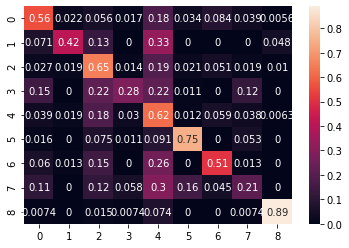

In [89]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation22, normalize='true')
sns.heatmap(cm, annot=True)

In [90]:
print(classification_report(validation['Genre'], lr_prediction_validation22))

              precision    recall  f1-score   support

      action       0.49      0.56      0.52       178
   adventure       0.49      0.42      0.45        84
      comedy       0.63      0.65      0.64       701
       crime       0.32      0.28      0.30        88
       drama       0.65      0.62      0.63       956
      horror       0.71      0.75      0.73       187
     romance       0.40      0.51      0.45       149
    thriller       0.29      0.21      0.25       154
     western       0.87      0.89      0.88       136

    accuracy                           0.60      2633
   macro avg       0.54      0.54      0.54      2633
weighted avg       0.60      0.60      0.60      2633



In [91]:
test = pd.read_csv('test.csv')
test['Predicted'] = best_pipe22.predict(test['Plot'])
test[['Id','Predicted']].to_csv('my_submissions_model_2-2.csv', index=False)

#### Model 2.3: SVM + TFIDF Transformer + Lemmatization

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')
  
def lemmatize_sentence(plot):
    plot_nlp = nlp(plot)
    lemmatized_sentence = " ".join([token.lemma_ for token in plot_nlp])
    return lemmatized_sentence

In [28]:
train['Plot_lemmatized'] = train['Plot'].apply(lemmatize_sentence)
validation['Plot_lemmatized'] = validation['Plot'].apply(lemmatize_sentence)

<ipython-input-28-b1bbafc48cac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_lemmatized'] = train['Plot'].apply(lemmatize_sentence)
<ipython-input-28-b1bbafc48cac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_lemmatized'] = validation['Plot'].apply(lemmatize_sentence)


In [92]:
pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words='english', max_df=0.7)),
                     ('tf_transfomer', TfidfTransformer(use_idf=True)),
                     ('classifier' , svm.SVC(class_weight = 'balanced', kernel = 'linear'))
                    ])

parameters = {'vectorizer__min_df' : [1, 3, 5],
              'vectorizer__ngram_range' : [(1,2), (1,3)],
              'classifier__C': [0.1, 1]
               }

grid23 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    n_jobs = 3,
                   verbose = 3,
                   scoring='f1_weighted')

In [93]:
grid23.fit(train['Plot_lemmatized'], train['Genre'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_df=0.7,
                                                        stop_words='english')),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            kernel='linear'))]),
             n_jobs=3,
             param_grid={'classifier__C': [0.1, 1],
                         'vectorizer__min_df': [1, 3, 5],
                         'vectorizer__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1_weighted', verbose=3)

In [94]:
print("The best algorithm:", grid23.best_estimator_)
print("Score of the best algorithm:", grid23.best_score_)

The best algorithm: Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 3),
                                 stop_words='english')),
                ('tf_transfomer', TfidfTransformer()),
                ('classifier',
                 SVC(C=1, class_weight='balanced', kernel='linear'))])
Score of the best algorithm: 0.592657309473219


In [95]:
pd.DataFrame(grid23.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_vectorizer__min_df,param_vectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,102.029870,1.217981,25.538712,0.034234,1,3,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.592721,0.594294,0.590956,0.592657,0.001363,1
8,99.695112,1.078575,24.961590,0.040035,1,3,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 3, ...",0.589844,0.593698,0.591889,0.591810,0.001574,2
6,180.767004,0.932929,33.855151,0.055727,1,1,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.585645,0.593644,0.591886,0.590392,0.003432,3
11,88.237456,0.265641,23.147799,0.401748,1,5,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 5, ...",0.586643,0.591009,0.585544,0.587732,0.002360,4
10,85.903335,0.341033,23.095235,0.103355,1,5,"(1, 2)","{'classifier__C': 1, 'vectorizer__min_df': 5, ...",0.586201,0.589824,0.585366,0.587130,0.001935,5
7,246.172327,0.963641,40.065858,0.054188,1,1,"(1, 3)","{'classifier__C': 1, 'vectorizer__min_df': 1, ...",0.571949,0.586459,0.588779,0.582395,0.007447,6
4,118.685987,1.033090,23.499824,0.157867,0.1,5,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.412603,0.302839,0.315363,0.343602,0.049059,7
5,123.536427,1.171064,25.450928,0.209463,0.1,5,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 5...",0.413143,0.302257,0.315333,0.343578,0.049479,8
2,129.993126,0.691769,24.978212,0.022138,0.1,3,"(1, 2)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.398729,0.275132,0.289953,0.321271,0.055104,9
3,132.639888,0.684078,25.563648,0.090970,0.1,3,"(1, 3)","{'classifier__C': 0.1, 'vectorizer__min_df': 3...",0.396655,0.274496,0.288845,0.319999,0.054520,10


In [96]:
best_pipe23 = grid23.best_estimator_
lr_prediction_validation23 = best_pipe23.predict(validation['Plot_lemmatized'])
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation23, average='weighted'))

Validation accuracy of the best algorithm: 0.6008164472490262


<AxesSubplot:>

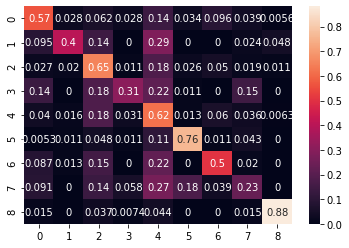

In [97]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation23, normalize='true')
sns.heatmap(cm, annot=True)

In [98]:
print(classification_report(validation['Genre'], lr_prediction_validation23))

              precision    recall  f1-score   support

      action       0.49      0.57      0.52       178
   adventure       0.47      0.40      0.44        84
      comedy       0.63      0.65      0.64       701
       crime       0.33      0.31      0.32        88
       drama       0.67      0.62      0.64       956
      horror       0.69      0.76      0.73       187
     romance       0.39      0.50      0.44       149
    thriller       0.31      0.23      0.26       154
     western       0.86      0.88      0.87       136

    accuracy                           0.60      2633
   macro avg       0.54      0.55      0.54      2633
weighted avg       0.60      0.60      0.60      2633



In [99]:
test = pd.read_csv('test.csv')
test_plot_lemmatized = test['Plot'].apply(lemmatize_sentence)
test['Predicted'] = best_pipe23.predict(test_plot_lemmatized)
test[['Id','Predicted']].to_csv('my_submissions_model_2-3.csv', index=False)

#### Model 2.4: SVM +  Word2Vec

In [38]:
def fast_tokenize(text):
    
    # Get a list of punctuation marks
    punct = string.punctuation + '“' + '”' + '‘' + "’"
    
    lower_case = text.lower()
    lower_case = lower_case.replace('—', ' ').replace('\n', ' ')
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in lower_case if char not in punct])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

In [39]:
import gensim.downloader as api
gn_model = api.load('word2vec-google-news-300')

C:\Users\aistm\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [40]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    tokens = fast_tokenize(doc)
    words = [word for word in tokens if word in gn_model]
    return np.mean(gn_model[words], axis=0)

In [41]:
train['Plot_w2v'] = train['Plot'].apply(document_vector)
validation['Plot_w2v'] = validation['Plot'].apply(document_vector)

<ipython-input-41-77cabf4aead4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_w2v'] = train['Plot'].apply(document_vector)
<ipython-input-41-77cabf4aead4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_w2v'] = validation['Plot'].apply(document_vector)


In [103]:
pipeline = Pipeline([
                     ('classifier' , svm.SVC(class_weight = 'balanced'))
                    ])

parameters = {'classifier__C': [0.01, 0.1, 1],
              'classifier__kernel': ['linear', 'poly']
               }

grid24 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [104]:
grid24.fit(list(train['Plot_w2v']), train['Genre'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__kernel': ['linear', 'poly']},
             scoring='f1_weighted', verbose=3)

In [105]:
print("The best algorithm:", grid24.best_estimator_)
print("Score of the best algorithm:", grid24.best_score_)

The best algorithm: Pipeline(steps=[('classifier',
                 SVC(C=1, class_weight='balanced', kernel='poly'))])
Score of the best algorithm: 0.5339250126183942


In [106]:
pd.DataFrame(grid24.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,34.456729,0.814163,10.005242,0.203235,1,poly,"{'classifier__C': 1, 'classifier__kernel': 'po...",0.538937,0.535720,0.527118,0.533925,0.004989,1
4,50.711248,0.729425,10.691738,0.074324,1,linear,"{'classifier__C': 1, 'classifier__kernel': 'li...",0.509744,0.501479,0.502191,0.504471,0.003739,2
3,109.526355,0.087910,23.433649,0.122863,0.1,poly,"{'classifier__C': 0.1, 'classifier__kernel': '...",0.461040,0.464861,0.462497,0.462799,0.001574,3
2,130.406500,0.975069,23.476534,0.458114,0.1,linear,"{'classifier__C': 0.1, 'classifier__kernel': '...",0.366395,0.358275,0.371648,0.365439,0.005501,4
1,137.734969,0.091972,22.813590,0.267472,0.01,poly,"{'classifier__C': 0.01, 'classifier__kernel': ...",0.214446,0.189470,0.191905,0.198607,0.011244,5
0,133.276597,2.738116,22.925512,0.228444,0.01,linear,"{'classifier__C': 0.01, 'classifier__kernel': ...",0.014741,0.008542,0.008542,0.010608,0.002923,6


In [107]:
best_pipe24 = grid24.best_estimator_
lr_prediction_validation24 = best_pipe24.predict(list(validation['Plot_w2v']))
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation24, average='weighted'))

Validation accuracy of the best algorithm: 0.5507173692882628


<AxesSubplot:>

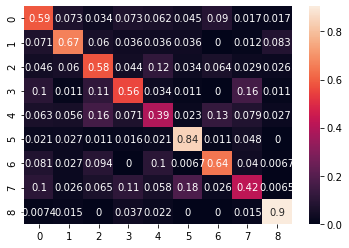

In [108]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation24, normalize='true')
sns.heatmap(cm, annot=True)

In [109]:
print(classification_report(validation['Genre'], lr_prediction_validation24))

              precision    recall  f1-score   support

      action       0.43      0.59      0.50       178
   adventure       0.31      0.67      0.42        84
      comedy       0.67      0.58      0.62       701
       crime       0.26      0.56      0.35        88
       drama       0.74      0.39      0.52       956
      horror       0.64      0.84      0.73       187
     romance       0.34      0.64      0.44       149
    thriller       0.33      0.42      0.37       154
     western       0.68      0.90      0.78       136

    accuracy                           0.55      2633
   macro avg       0.49      0.62      0.53      2633
weighted avg       0.62      0.55      0.55      2633



In [120]:
test = pd.read_csv('test.csv')
test_plot_w2v = test['Plot'].apply(document_vector)
test['Predicted'] = best_pipe24.predict(list(test_plot_w2v))
test[['Id','Predicted']].to_csv('my_submissions_model_2-4.csv', index=False)

#### Model 2.5: SVM + Lemmatization + Word2Vec

In [48]:
train['Plot_w2v_lemmatized'] = train['Plot_lemmatized'].apply(document_vector)
validation['Plot_w2v_lemmatized'] = validation['Plot_lemmatized'].apply(document_vector)

<ipython-input-48-1a664ee817aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Plot_w2v_lemmatized'] = train['Plot_lemmatized'].apply(document_vector)
<ipython-input-48-1a664ee817aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Plot_w2v_lemmatized'] = validation['Plot_lemmatized'].apply(document_vector)


In [110]:
pipeline = Pipeline([
                     ('classifier' , svm.SVC(class_weight = 'balanced'))
                    ])

parameters = {'classifier__C': [0.01, 0.1, 1],
              'classifier__kernel': ['linear', 'poly']
               }

grid25 = GridSearchCV(pipeline, 
                    parameters, 
                    cv = 3,
                    n_jobs = -1,
                   verbose = 3,
                   scoring='f1_weighted')

In [111]:
grid25.fit(list(train['Plot_w2v_lemmatized']), train['Genre'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1],
                         'classifier__kernel': ['linear', 'poly']},
             scoring='f1_weighted', verbose=3)

In [112]:
print("The best algorithm:", grid25.best_estimator_)
print("Score of the best algorithm:", grid25.best_score_)

The best algorithm: Pipeline(steps=[('classifier',
                 SVC(C=1, class_weight='balanced', kernel='poly'))])
Score of the best algorithm: 0.5246053136987586


In [113]:
pd.DataFrame(grid25.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,33.864746,0.938162,9.970330,0.133292,1,poly,"{'classifier__C': 1, 'classifier__kernel': 'po...",0.529976,0.526655,0.517184,0.524605,0.005420,1
4,51.006164,1.255913,10.678766,0.081041,1,linear,"{'classifier__C': 1, 'classifier__kernel': 'li...",0.497602,0.494915,0.499177,0.497231,0.001759,2
3,111.723979,1.526132,22.870456,0.469492,0.1,poly,"{'classifier__C': 0.1, 'classifier__kernel': '...",0.445816,0.452416,0.457603,0.451945,0.004823,3
2,132.600536,1.398169,24.298572,0.079726,0.1,linear,"{'classifier__C': 0.1, 'classifier__kernel': '...",0.348690,0.335385,0.353821,0.345965,0.007769,4
1,137.489821,0.768325,22.880365,0.174998,0.01,poly,"{'classifier__C': 0.01, 'classifier__kernel': ...",0.178086,0.174443,0.169908,0.174145,0.003345,5
0,134.107869,1.164657,23.250043,0.293759,0.01,linear,"{'classifier__C': 0.01, 'classifier__kernel': ...",0.015808,0.008542,0.008542,0.010964,0.003425,6


In [114]:
best_pipe25 = grid25.best_estimator_
lr_prediction_validation25 = best_pipe25.predict(list(validation['Plot_w2v_lemmatized']))
print("Validation accuracy of the best algorithm:", f1_score(validation['Genre'], lr_prediction_validation25, average='weighted'))

Validation accuracy of the best algorithm: 0.5401946623545986


<AxesSubplot:>

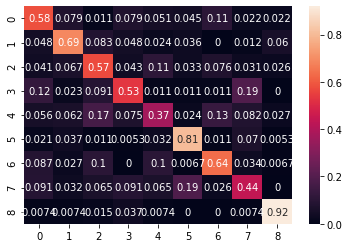

In [115]:
cm = confusion_matrix(validation['Genre'], lr_prediction_validation25, normalize='true')
sns.heatmap(cm, annot=True)

In [116]:
print(classification_report(validation['Genre'], lr_prediction_validation25))

              precision    recall  f1-score   support

      action       0.44      0.58      0.50       178
   adventure       0.29      0.69      0.41        84
      comedy       0.66      0.57      0.62       701
       crime       0.25      0.53      0.34        88
       drama       0.75      0.37      0.50       956
      horror       0.63      0.81      0.71       187
     romance       0.31      0.64      0.42       149
    thriller       0.33      0.44      0.37       154
     western       0.69      0.92      0.79       136

    accuracy                           0.53      2633
   macro avg       0.49      0.62      0.52      2633
weighted avg       0.61      0.53      0.54      2633



In [121]:
test = pd.read_csv('test.csv')
test_plot_w2v_lemmatized = test_plot_lemmatized.apply(document_vector)
test['Predicted'] = best_pipe25.predict(list(test_plot_w2v_lemmatized))
test[['Id','Predicted']].to_csv('my_submissions_model_2-5.csv', index=False)